In [1]:
import numpy as np
import pandas as pd

import os
import re

import datetime
from pv_model_function import *
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pvlib


In [2]:
data_pt = os.path.join('data', "222628_32.73_-117.18_2012.csv")

lat, lon = 32.73, -117.18
offset = 7

In [3]:
nsrdb = pd.read_csv(data_pt, skiprows=2, usecols=['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'DHI', 'GHI',
       'DNI', 'Surface Albedo', 'Wind Speed', 'Pressure'])
local_index = pd.DatetimeIndex(nsrdb['Year'].astype(str) + '-' + nsrdb['Month'].astype(str) +
                             '-' + nsrdb['Day'].astype(str) + ' ' + nsrdb['Hour'].astype(str) +
                               ':' + nsrdb['Minute'].astype(str))
nsrdb.set_index(local_index, inplace=True)

In [4]:
start_date = str(nsrdb.index[0])
end_date = str(nsrdb.index[-1])

times_interp = pd.date_range(start_date, end_date, freq='5min')

nsrdb_interpolated = pd.DataFrame(index=times_interp)
nsrdb_interpolated['dni_extra'] = pvlib.irradiance.get_extra_radiation(nsrdb_interpolated.index)
times_float = times_interp.to_numpy().astype(float)
for i in nsrdb.columns:
    cs = CubicSpline(nsrdb.index.to_numpy().astype(float), nsrdb[i].values)
    nsrdb_interpolated[i] = cs(times_float)
    nsrdb_interpolated[i] = np.maximum(nsrdb_interpolated[i], 0)

In [5]:

loc = pvlib.location.Location(lat,lon, altitude=0)
fake_index = pd.date_range(datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=-offset),
                           datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=offset), freq='5min')
solar_position = loc.get_solarposition(times=fake_index)
solar_position.set_index(solar_position.index.shift(periods=-offset, freq = '1h'), inplace = True)
solar_position = solar_position.loc[times_interp]
data = pd.concat([nsrdb_interpolated, solar_position], axis=1)

In [8]:
tracking_pvw = model_pv_plant_tracking(data)
west_pvw = model_pv_plant_vertical(data)
fixed_pvw = model_pv_plant_fixed_tilt(data)

In [14]:
load_pt = os.path.join('data', "Project 2 - Load Profile.csv")
load = pd.read_csv(load_pt)
load = load[:105408]

In [15]:
new_idx = []
for i in load.index: 
    string = load['Datetime'][i]
    match = re.search(r'(\d+)/(\d+)/(\d+)\W+(\d+):(\d+)', string)
    new_datetime = datetime.datetime(2012, int(match.group(1)), int(match.group(2)), int(match.group(4)), int(match.group(5)))
    new_idx.append(new_datetime)
load.set_index(pd.DatetimeIndex(new_idx), inplace=True)
load = pd.Series(load['Load (MW)'])*1000**2

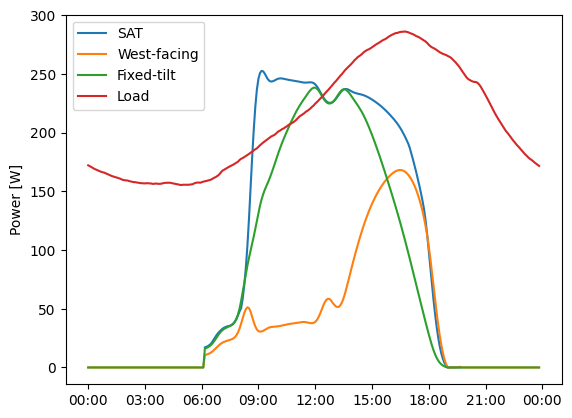

In [18]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

start = '2012-08-02 00:00:00'
end = '2012-08-02 23:50:00'
idx = data[start:end].index
ax.plot(idx, tracking_pvw[idx], label='SAT')
ax.plot(idx, west_pvw[idx], label='West-facing')
ax.plot(idx, fixed_pvw[idx], label='Fixed-tilt')
ax.plot(idx, load[idx]*0.002**2, label='Load')
ax.set_ylabel('Power [W]')
ax.legend();